# e-commerce Dataset

https://www.kaggle.com/datasets/carrie1/ecommerce-data

#EDA

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=cea31fa2494f7150ed7914df53c24cb3ed676d4d4da2ffef8b94727bb27511fc
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [31]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType,
    ArrayType, MapType, DateType, TimestampType
)
from pyspark.sql.functions import (
    col, size, lit, explode,
    concat, concat_ws, substring,
    datediff, date_add, date_sub,
    year, month, dayofmonth, dayofweek, dayofyear, weekofyear,
    hour, minute, second,
    count, min, max, avg, sum, udf, when,
    to_timestamp
)
from datetime import datetime

In [32]:
spark = SparkSession.builder.appName("Ecommerce").getOrCreate()

In [4]:
df = spark.read.csv("/content/data.csv", header=True, inferSchema=True)

In [8]:
df.show(10, truncate=False)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |22752    |SET 7 BABUSHKA NESTING BOXES       

In [7]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [9]:
print(f"Ilość wierszy: {df.count()}")

Ilość wierszy: 541909


In [11]:
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|         541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|           NULL|4.611113626082972|15287.690570239585|       NULL|
| stddev|13428.417280800133| 16799.73762842775|                NULL|218.08115785023486|           NULL| 96.7598530611797| 1713.600303321594|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -8

In [12]:
# Sprawdza brakujące wartości (null lub NaN) w każdej kolumnie.

df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [14]:
df.columns

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [15]:
df = df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

In [17]:
df.groupBy("Country").sum("TotalPrice").orderBy("sum(TotalPrice)", ascending=False).show(5)

+--------------+------------------+
|       Country|   sum(TotalPrice)|
+--------------+------------------+
|United Kingdom| 8187806.363998687|
|   Netherlands| 284661.5399999992|
|          EIRE| 263276.8199999992|
|       Germany|221698.21000000037|
|        France|197403.90000000037|
+--------------+------------------+
only showing top 5 rows



In [20]:
df.groupBy("InvoiceDate").count().orderBy(("InvoiceDate"), ascending=True).show(5)

+---------------+-----+
|    InvoiceDate|count|
+---------------+-----+
|1/10/2011 10:04|    1|
|1/10/2011 10:07|    1|
|1/10/2011 10:08|    1|
|1/10/2011 10:32|   23|
|1/10/2011 10:35|   17|
+---------------+-----+
only showing top 5 rows



In [21]:
df.groupBy("InvoiceDate").count().orderBy(("InvoiceDate"), ascending=False).show(5)

+-------------+-----+
|  InvoiceDate|count|
+-------------+-----+
|9/9/2011 9:52|   37|
|9/9/2011 9:38|   14|
|9/9/2011 9:13|   45|
|9/9/2011 9:03|   14|
|9/9/2011 8:48|   16|
+-------------+-----+
only showing top 5 rows



In [ ]:
# spark.stop()

#Sales Value Analysis

In [23]:
# Całkowita wartość sprzedaży per produkt
df.groupBy("Description").sum("TotalPrice").orderBy("sum(TotalPrice)", ascending=False).show(10, truncate=False)

+----------------------------------+------------------+
|Description                       |sum(TotalPrice)   |
+----------------------------------+------------------+
|DOTCOM POSTAGE                    |206245.48000000007|
|REGENCY CAKESTAND 3 TIER          |164762.1899999997 |
|WHITE HANGING HEART T-LIGHT HOLDER|99668.4699999996  |
|PARTY BUNTING                     |98302.98000000023 |
|JUMBO BAG RED RETROSPOT           |92356.03000000058 |
|RABBIT NIGHT LIGHT                |66756.59000000019 |
|POSTAGE                           |66230.64          |
|PAPER CHAIN KIT 50'S CHRISTMAS    |63791.939999999944|
|ASSORTED COLOUR BIRD ORNAMENT     |58959.73000000042 |
|CHILLI LIGHTS                     |53768.05999999991 |
+----------------------------------+------------------+
only showing top 10 rows



In [24]:
# Całkowita sprzedaż per kraj
df.groupBy("Country").sum("TotalPrice").orderBy("sum(TotalPrice)", ascending=False).show(10, truncate=False)

+--------------+------------------+
|Country       |sum(TotalPrice)   |
+--------------+------------------+
|United Kingdom|8187806.363998687 |
|Netherlands   |284661.5399999992 |
|EIRE          |263276.8199999992 |
|Germany       |221698.21000000037|
|France        |197403.90000000037|
|Australia     |137077.26999999987|
|Switzerland   |56385.35000000011 |
|Spain         |54774.58000000016 |
|Belgium       |40910.960000000014|
|Sweden        |36595.90999999998 |
+--------------+------------------+
only showing top 10 rows



In [25]:
df.groupBy("CustomerID").sum("TotalPrice").orderBy("sum(TotalPrice)", ascending=False).show(10)

+----------+------------------+
|CustomerID|   sum(TotalPrice)|
+----------+------------------+
|      NULL|  1447682.12000015|
|     14646|279489.01999999944|
|     18102|256438.48999999993|
|     17450|187482.16999999998|
|     14911|132572.61999999988|
|     12415| 123725.4499999999|
|     14156|113384.13999999998|
|     17511| 88125.37999999992|
|     16684| 65892.07999999999|
|     13694|62653.100000000006|
+----------+------------------+
only showing top 10 rows



# Analysis of purchasing behavior

In [33]:
# Konwersja InvoiceDate na typ Timestamp
df = df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "M/d/yyyy H:mm"))

In [38]:
# Ilość transakcji w każdym miesiącu (analiza sezonowości)
df.groupBy(month("InvoiceDate").alias("Month")).count().orderBy("Month").show()

+-----+-----+
|Month|count|
+-----+-----+
|    1|35147|
|    2|27707|
|    3|36748|
|    4|29916|
|    5|37030|
|    6|36874|
|    7|39518|
|    8|35284|
|    9|50226|
|   10|60742|
|   11|84711|
|   12|68006|
+-----+-----+



In [41]:
# Grupowanie po roku i miesiącu, liczenie transakcji
df.groupBy(year("InvoiceDate").alias("Year"), month("InvoiceDate").alias("Month")) \
  .count() \
  .orderBy("Year", "Month") \
  .show()

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2010|   12|42481|
|2011|    1|35147|
|2011|    2|27707|
|2011|    3|36748|
|2011|    4|29916|
|2011|    5|37030|
|2011|    6|36874|
|2011|    7|39518|
|2011|    8|35284|
|2011|    9|50226|
|2011|   10|60742|
|2011|   11|84711|
|2011|   12|25525|
+----+-----+-----+



In [39]:
df.groupBy(dayofweek("InvoiceDate").alias("DayOfWeek")).count().orderBy("DayOfWeek").show()

+---------+------+
|DayOfWeek| count|
+---------+------+
|        1| 64375|
|        2| 95111|
|        3|101808|
|        4| 94565|
|        5|103857|
|        6| 82193|
+---------+------+



In [40]:
df.groupBy(hour("InvoiceDate").alias("Hour")).count().orderBy("Hour").show()

+----+-----+
|Hour|count|
+----+-----+
|   6|   41|
|   7|  383|
|   8| 8909|
|   9|34332|
|  10|49037|
|  11|57674|
|  12|78709|
|  13|72259|
|  14|67471|
|  15|77519|
|  16|54516|
|  17|28509|
|  18| 7974|
|  19| 3705|
|  20|  871|
+----+-----+



#Margin and Profitability Analysis

In [ ]:
# Przykład analizy rentowności (zakładając, że mamy kolumnę CostPrice)
df = df.withColumn("Profit", (col("UnitPrice") - col("CostPrice")) * col("Quantity"))

In [ ]:
# Najbardziej rentowne produkty
df.groupBy("Description").sum("Profit").orderBy("sum(Profit)", ascending=False).show(10)

#Customer segmentation

In [42]:
df.groupBy("CustomerID").count().filter(col("count") == 1).show()

+----------+-----+
|CustomerID|count|
+----------+-----+
|     15070|    1|
|     12943|    1|
|     16738|    1|
|     18113|    1|
|     16078|    1|
|     17448|    1|
|     16138|    1|
|     17331|    1|
|     16148|    1|
|     14351|    1|
|     17715|    1|
|     16323|    1|
|     18068|    1|
|     13829|    1|
|     17307|    1|
|     15562|    1|
|     16061|    1|
|     13120|    1|
|     15753|    1|
|     13154|    1|
+----------+-----+
only showing top 20 rows



In [46]:
df.groupBy("CustomerID").count().filter(col("count") == 1).show()

+----------+-----+
|CustomerID|count|
+----------+-----+
|     15070|    1|
|     12943|    1|
|     16738|    1|
|     18113|    1|
|     16078|    1|
|     17448|    1|
|     16138|    1|
|     17331|    1|
|     16148|    1|
|     14351|    1|
|     17715|    1|
|     16323|    1|
|     18068|    1|
|     13829|    1|
|     17307|    1|
|     15562|    1|
|     16061|    1|
|     13120|    1|
|     15753|    1|
|     13154|    1|
+----------+-----+
only showing top 20 rows



In [47]:
df.groupBy("CustomerID").count().filter(col("count") == 1).count()

79

In [55]:
df.groupBy("CustomerID") \
.count() \
.filter(col("count") > 1) \
.orderBy("count", ascending=False).show()

+----------+------+
|CustomerID| count|
+----------+------+
|      NULL|135080|
|     17841|  7983|
|     14911|  5903|
|     14096|  5128|
|     12748|  4642|
|     14606|  2782|
|     15311|  2491|
|     14646|  2085|
|     13089|  1857|
|     13263|  1677|
|     14298|  1640|
|     15039|  1508|
|     14156|  1420|
|     18118|  1284|
|     14159|  1212|
|     14796|  1165|
|     15005|  1160|
|     16033|  1152|
|     14056|  1128|
|     14769|  1094|
+----------+------+
only showing top 20 rows



In [61]:
premium_customers = df.groupBy("CustomerID").agg(sum("TotalPrice").alias("TotalSpent"))
premium_customers_filtered = premium_customers.filter(col("TotalSpent") > 1000)
premium_customers_filtered.orderBy(col("TotalSpent"), ascending=False).show()

+----------+------------------+
|CustomerID|        TotalSpent|
+----------+------------------+
|      NULL|  1447682.12000015|
|     14646|279489.01999999944|
|     18102|256438.48999999993|
|     17450|187482.16999999998|
|     14911|132572.61999999988|
|     12415| 123725.4499999999|
|     14156|113384.13999999998|
|     17511| 88125.37999999992|
|     16684| 65892.07999999999|
|     13694|62653.100000000006|
|     15311|59419.340000000084|
|     13089| 57385.88000000011|
|     14096| 57120.90999999968|
|     15061|54228.740000000005|
|     17949| 52750.84000000001|
|     15769|          51823.72|
|     16029| 50992.60999999996|
|     14298| 50862.43999999991|
|     14088|50415.489999999976|
|     17841|40340.780000000246|
+----------+------------------+
only showing top 20 rows



#Pandas

In [64]:
country_sales = df.groupBy("Country").agg(sum("TotalPrice").alias("TotalSpent"))
country_sales_ordered = country_sales.orderBy(col("TotalSpent"), ascending=False)

In [65]:
country_sales_pandas = country_sales_ordered.toPandas()

print(country_sales_pandas.head())

          Country    TotalSpent
0  United Kingdom  8.187806e+06
1     Netherlands  2.846615e+05
2            EIRE  2.632768e+05
3         Germany  2.216982e+05
4          France  1.974039e+05


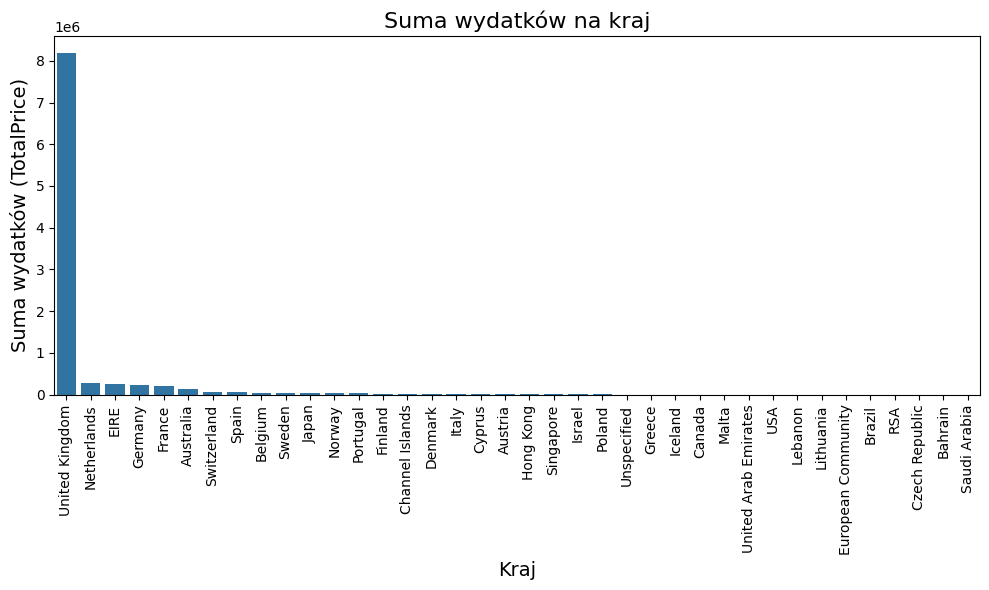

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='TotalSpent', data=country_sales_pandas)
plt.title('Suma wydatków na kraj', fontsize=16)
plt.xlabel('Kraj', fontsize=14)
plt.ylabel('Suma wydatków (TotalPrice)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()